<a href="https://colab.research.google.com/github/amanjain487/tsai-eva6/blob/main/Assignments/S6/model2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt


# Define Model Architecture
Lets define the convolution blocks and the forward function.

In [15]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # RF = 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, bias=False),
            nn.LayerNorm(28),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 28x28x1
        # output_size = 28x28x32
        # RF = 3


        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 10, 1, padding=0, bias=False),
            nn.Conv2d(10, 10, 3, padding=1, bias=False),
            nn.LayerNorm(28),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 28x28x32
        # output_size = 28x28x10
        # RF = 5

        self.pool1 = nn.MaxPool2d(2, 2) 
        # input_size = 28x28x10
        # output_size = 14x14x10
        # RF = 10


        self.conv3 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.LayerNorm(12),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 14x14x10
        # output_size = 12x12x10
        # RF = 12

        self.conv4 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.LayerNorm(10),
            nn.ReLU()
        ) 
        # input_size = 12x12x10
        # output_size = 10x10x10
        # RF = 14

        self.conv5 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=0, bias=False),
            nn.LayerNorm(8),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 10x10x10
        # output_size = 8x8x10
        # RF = 16

        self.conv6 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=0, bias=False),
            nn.LayerNorm(6),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 8x8x10
        # output_size = 6x6x16
        # RF = 18

        self.conv7 = nn.Sequential(
            nn.Conv2d(16, 10, 3, padding=0, bias=False),
            nn.LayerNorm(4),
            nn.Dropout(0.01),
            nn.ReLU()
        ) 
        # input_size = 6x6x16
        # output_size = 4x4x10
        # RF = 20

        self.gap1 = nn.AvgPool2d(4) 
        # input_size = 4x4x10
        # output_size = 1x1x10
        # RF = 20

        self.fc1 = nn.Sequential(
            nn.Linear(10, 10, bias=False)
        ) 
        # input_size = 1x1x10
        # output_size = 1x1x10
        # RF = 20

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.gap1(x)
        x = x.reshape(-1,10)
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Summary and Paramters
Print the model parameters and output shape at each layer by giving dummy input to torchsummary

In [16]:
!pip install torchsummary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
         LayerNorm-2           [-1, 32, 28, 28]              56
           Dropout-3           [-1, 32, 28, 28]               0
              ReLU-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 10, 28, 28]             320
            Conv2d-6           [-1, 10, 28, 28]             900
         LayerNorm-7           [-1, 10, 28, 28]              56
           Dropout-8           [-1, 10, 28, 28]               0
              ReLU-9           [-1, 10, 28, 28]               0
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 10, 12, 12]             900
        LayerNorm-12           [-1, 10, 12, 12]              24
          Dropout-13           [-1, 10, 12, 12]               0
             ReLU-14           [-1

# Split Dataset into Train set and Test set

In [17]:
train_set = datasets.MNIST('../data', 
                   train=True, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.RandomRotation((-7.5, 7.5), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       ]))


test_set = datasets.MNIST('../data', 
                   train=False, 
                   download=True,
                   transform=transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ]))

# Create Data Loaders for Train and Test set

In [18]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)

batch_size=128

kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}


train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

# Define Train and Test Functions

In [32]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    correct = 0
    processed = 0
    total_loss = 0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        total_loss += loss
        loss.backward()
        optimizer.step()
        predictions = output.argmax(dim=1, keepdim=True)
        correct += predictions.eq(target.view_as(predictions)).sum().item()
        processed += len(data)
    training_losses.append(loss)
    training_accuracy.append(100*correct/processed)
    #pbar.set_description(desc= f'Train set: Accuracy={100*correct/processed:0.1f}')
    print('Train set: Accuracy={:0.1f}'.format(100*correct/processed))
    print('Loss - ', loss)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            predictions = output.argmax(dim=1, keepdim=True)
            correct += predictions.eq(target.view_as(predictions)).sum().item()

    test_loss /= len(test_loader.dataset)
    testing_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    testing_accuracy.append(100. * correct / len(test_loader.dataset))

# Train and Test the Model
Use LR Scheduling

In [33]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

# will be used while plotting graphs

training_losses = []
testing_losses = []
training_accuracy = []
testing_accuracy = []


model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.001)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

for epoch in range(1, 20):
    print("EPOCH:", epoch, "LR = ", scheduler.get_lr())
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()


EPOCH: 1 LR =  [0.01]


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


Train set: Accuracy=39.3
Loss -  tensor(0.4256, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.4709, Accuracy: 8974/10000 (89.7%)

EPOCH: 2 LR =  [0.01]
Train set: Accuracy=93.7
Loss -  tensor(0.1637, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.1079, Accuracy: 9718/10000 (97.2%)

EPOCH: 3 LR =  [0.01]
Train set: Accuracy=96.4
Loss -  tensor(0.0380, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.0905, Accuracy: 9748/10000 (97.5%)

EPOCH: 4 LR =  [0.01]
Train set: Accuracy=97.1
Loss -  tensor(0.0986, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.0721, Accuracy: 9804/10000 (98.0%)

EPOCH: 5 LR =  [0.01]
Train set: Accuracy=97.6
Loss -  tensor(0.0851, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.0599, Accuracy: 9835/10000 (98.3%)

EPOCH: 6 LR =  [0.01]
Train set: Accuracy=97.8
Loss -  tensor(0.1654, device='cuda:0', grad_fn=<NllLossBackward>)
Test set: Average loss: 0.05

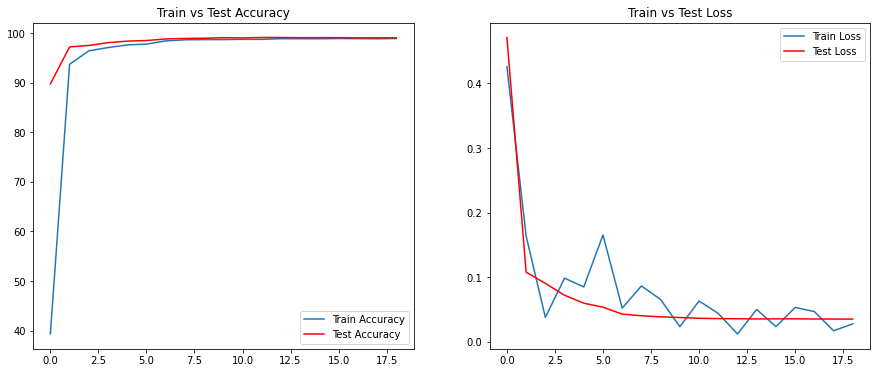

In [34]:
import numpy as np
plt.rcParams['figure.figsize'] = [15, 6]

def training_curves():
  plt.subplot(1,2, 1)

  plt.plot(np.array(training_accuracy))
  plt.plot(np.array(testing_accuracy), 'r')
  plt.legend(["Train Accuracy", "Test Accuracy"])
  plt.title("Train vs Test Accuracy")

  plt.subplot(1,2,2)
  plt.plot(training_losses)
  plt.plot(testing_losses, 'r')
  plt.legend(["Train Loss", "Test Loss"])
  plt.title("Train vs Test Loss")

training_curves()